### CICIDS_2017 LSTM_AE

In [1]:
import pandas as pd
import numpy as np

from glob import glob

In [2]:
file_list = []

data_path = './data/MachineLearningCSV/MachineLearningCVE'
all_files = glob(data_path + "/*.csv")

li = []

for filename in all_files:
  df = pd.read_csv(filename, index_col=None, header=0)
  li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

In [3]:
df.columns = df.columns.str.strip()

In [4]:
infinity_values = df.isin([np.inf, -np.inf]).sum()
infinity_values[infinity_values != 0]

Flow Bytes/s      1509
Flow Packets/s    2867
dtype: int64

In [5]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [6]:
null_values = df.isna().sum()
null_values[null_values != 0]

Flow Bytes/s      2867
Flow Packets/s    2867
dtype: int64

In [7]:
df.dropna(axis=0, inplace=True)

In [8]:
label = df['Label']
labels = label.unique()
classes = label.nunique()
print("number of labels:", classes)
print("instances per label\n", label.value_counts())
print("labels:", labels)

number of labels: 15
instances per label
 BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: Label, dtype: int64
labels: ['BENIGN' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'DoS slowloris' 'DoS Slowhttptest'
 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed' 'Bot' 'DDoS' 'FTP-Patator'
 'SSH-Patator' 'Infiltration' 'PortScan']


In [9]:
df_experiment = df.copy()
df_experiment.Label.replace("Web.*", "Web Attack", regex=True, inplace=True)
df_experiment.Label.replace(r'.*Patator$', "Brute Force", regex=True,inplace=True)
df_experiment.Label.replace(["DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris"], "DoS", inplace=True)
df_experiment.Label.value_counts()

BENIGN          2271320
DoS              251712
PortScan         158804
DDoS             128025
Brute Force       13832
Web Attack         2180
Bot                1956
Infiltration         36
Heartbleed           11
Name: Label, dtype: int64

In [10]:
# data split
from sklearn.model_selection import train_test_split
from collections import Counter
y = df_experiment.Label
X = df_experiment.drop(columns='Label')
labels = y.unique()

# label count check
classes = y.nunique()
print(X.shape)
print("number of labels:", classes)
print("instances per label\n", y.value_counts())
print("labels:", labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

print("after spliting the data:\n")
print("training data length:", len(X_train))
print("test data length:", len(X_test))

(2827876, 78)
number of labels: 9
instances per label
 BENIGN          2271320
DoS              251712
PortScan         158804
DDoS             128025
Brute Force       13832
Web Attack         2180
Bot                1956
Infiltration         36
Heartbleed           11
Name: Label, dtype: int64
labels: ['BENIGN' 'Web Attack' 'DoS' 'Heartbleed' 'Bot' 'DDoS' 'Brute Force'
 'Infiltration' 'PortScan']
after spliting the data:

training data length: 2120907
test data length: 706969


autoencoder는 따로 BENIGN, Attack으로 Binary category화 하지않고 label 속성 그대로 살려두고 reconstruction error를 계산하여 Anomaly Detect진행

In [11]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
scaler = MinMaxScaler()
le = LabelEncoder()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("instances per label in training set\n", y_train.value_counts())
y_train = le.fit_transform(y_train)
print("instances per label in test set\n", y_test.value_counts())
y_test = le.transform(y_test)

print(X_train.shape)
print(X_test.shape)
labels_dict = dict(zip(le.classes_, range(len(le.classes_))))
print(labels_dict)


instances per label in training set
 BENIGN          1703490
DoS              188784
PortScan         119103
DDoS              96019
Brute Force       10374
Web Attack         1635
Bot                1467
Infiltration         27
Heartbleed            8
Name: Label, dtype: int64
instances per label in test set
 BENIGN          567830
DoS              62928
PortScan         39701
DDoS             32006
Brute Force       3458
Web Attack         545
Bot                489
Infiltration         9
Heartbleed           3
Name: Label, dtype: int64
(2120907, 78)
(706969, 78)
{'BENIGN': 0, 'Bot': 1, 'Brute Force': 2, 'DDoS': 3, 'DoS': 4, 'Heartbleed': 5, 'Infiltration': 6, 'PortScan': 7, 'Web Attack': 8}


In [12]:
X.shape

(2827876, 78)

In [13]:
X.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,...,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06,2.827876e+06
mean,8.061534e+03,1.480065e+07,9.368972e+00,1.040396e+01,5.498522e+02,1.617903e+04,2.078044e+02,1.872929e+01,5.825628e+01,6.897811e+01,...,5.423519e+00,-2.744494e+03,8.163400e+04,4.117582e+04,1.533378e+05,5.835492e+04,8.324468e+06,5.043548e+05,8.704568e+06,7.928061e+06
std,1.827432e+04,3.366750e+07,7.500527e+02,9.978937e+02,9.998639e+03,2.264235e+06,7.175183e+02,6.035533e+01,1.861733e+02,2.813212e+02,...,6.367482e+02,1.085539e+06,6.489234e+05,3.935787e+05,1.026333e+06,5.773818e+05,2.364057e+07,4.605289e+06,2.437766e+07,2.337390e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,1.550000e+02,2.000000e+00,1.000000e+00,1.200000e+01,2.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,3.133800e+04,2.000000e+00,2.000000e+00,6.200000e+01,1.230000e+02,3.700000e+01,2.000000e+00,3.400000e+01,0.000000e+00,...,1.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,3.239368e+06,5.000000e+00,4.000000e+00,1.880000e+02,4.840000e+02,8.100000e+01,3.600000e+01,5.000000e+01,2.616295e+01,...,2.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [14]:
from tensorflow.keras import Model, Sequential, Input, backend
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
import tensorflow as tf

In [15]:
# def autoencoder_model(X):
#     inputs = Input(shape=(X.shape[1], X.shape[2]))
#     L1 = LSTM(16, activation='relu', return_sequences=True, 
#               kernel_regularizer=regularizers.l1(10-5))(inputs)
#     L2 = LSTM(8, activation='relu', return_sequences=False)(L1)
#     L3 = RepeatVector(X.shape[1])(L2)
#     L4 = LSTM(8, activation='relu', return_sequences=True)(L3)
#     L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
#     output = TimeDistributed(Dense(X.shape[2]))(L5)    
#     model = Model(inputs=inputs, outputs=output)
#     return model

In [16]:
callback = EarlyStopping(patience=5, mode='min')

input_shape = X_train.shape[1]
print(f"input shape: {input_shape}")
encoding_dim = 10
encoder = Sequential([
    Dense(32, activation='relu', input_shape=(input_shape, )),
    Dense(encoding_dim, activation='relu')
])
decoder = Sequential([
    Dense(32, activation='relu', input_shape=(encoding_dim,)),
    Dense(input_shape)
])
autoencoder = Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer='Adam')
history = autoencoder.fit(X_train, X_train, batch_size=64,
                          epochs=20, validation_split=0.2)

input shape: 78


2022-05-25 02:18:42.141147: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-25 02:18:42.770243: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30974 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2022-05-25 02:18:46.270825: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
26512/26512 [==============================] - 58s 2ms/step - loss: 6.8166e-04 - val_loss: 2.4016e-04
Epoch 2/20
26512/26512 [==============================] - 56s 2ms/step - loss: 2.0734e-04 - val_loss: 1.8241e-04
Epoch 3/20
26512/26512 [==============================] - 56s 2ms/step - loss: 1.5788e-04 - val_loss: 1.4258e-04
Epoch 4/20
26512/26512 [==============================] - 61s 2ms/step - loss: 1.3907e-04 - val_loss: 1.2885e-04
Epoch 5/20
26512/26512 [==============================] - 64s 2ms/step - loss: 1.2652e-04 - val_loss: 1.1403e-04
Epoch 6/20
26512/26512 [==============================] - 64s 2ms/step - loss: 1.1153e-04 - val_loss: 1.1019e-04
Epoch 7/20
26512/26512 [==============================] - 63s 2ms/step - loss: 1.0366e-04 - val_loss: 1.0770e-04
Epoch 8/20
26512/26512 [==============================] - 62s 2ms/step - loss: 9.8820e-05 - val_loss: 9.1847e-05
Epoch 9/20
26512/26512 [==============================] - 63s 2ms/step - loss: 9.1230e-05 - val_

In [17]:
X_train = encoder.predict(X_train)
X_test = encoder.predict(X_test)

In [18]:
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print(f"shape of X_train:", X_train_lstm.shape)
print(f"shape of X_test:", X_test_lstm.shape)
# X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# print("Training data shape:", X_train.shape)
# X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
# print("Test data shape:", X_test.shape)

shape of X_train: (2120907, 1, 10)
shape of X_test: (706969, 1, 10)


In [19]:
n_classes = len(le.classes_)
print(f"num of classes:{n_classes}")
n_features = X_train_lstm.shape[2]
def multiClassModel(n_features, n_classes=9):
    model = Sequential()
    model.add(Input(shape=(None, n_features)))
#     model.add(LSTM(units=30))
    model.add(LSTM(units=78))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation="softmax", name="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer='Adam')
    model.summary()
    return model

num of classes:9


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 78)                27768     
_________________________________________________________________
dropout (Dropout)            (None, 78)                0         
_________________________________________________________________
softmax (Dense)              (None, 9)                 711       
Total params: 28,479
Trainable params: 28,479
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


2022-05-25 02:39:05.927812: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


26512/26512 [==============================] - 90s 3ms/step - loss: 0.2241 - val_loss: 0.1524
Epoch 2/200
26512/26512 [==============================] - 88s 3ms/step - loss: 0.1503 - val_loss: 0.1303
Epoch 3/200
26512/26512 [==============================] - 87s 3ms/step - loss: 0.1331 - val_loss: 0.1181
Epoch 4/200
26512/26512 [==============================] - 87s 3ms/step - loss: 0.1229 - val_loss: 0.1122
Epoch 5/200
26512/26512 [==============================] - 87s 3ms/step - loss: 0.1170 - val_loss: 0.1086
Epoch 6/200
26512/26512 [==============================] - 87s 3ms/step - loss: 0.1126 - val_loss: 0.1043
Epoch 7/200
26512/26512 [==============================] - 87s 3ms/step - loss: 0.1090 - val_loss: 0.1011
Epoch 8/200
26512/26512 [==============================] - 87s 3ms/step - loss: 0.1064 - val_loss: 0.0999
Epoch 9/200
26512/26512 [==============================] - 87s 3ms/step - loss: 0.1040 - val_loss: 0.0978
Epoch 10/200
26512/26512 [==============================] 

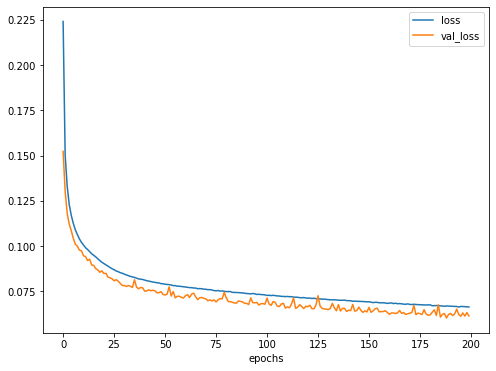

In [20]:
callback = EarlyStopping(patience=20, mode='min', restore_best_weights=True)
backend.clear_session()
model = multiClassModel(n_features, n_classes)
history = model.fit(X_train_lstm, y_train, 
                    epochs=200, batch_size=64, validation_split=0.2, callbacks=[callback])
### check the loss trend of epochs
pd.DataFrame(history.history).plot(kind='line', xlabel='epochs', figsize=(8, 6))

import matplotlib.pyplot as plt
plt.show()

In [22]:
y_train_pred_prob = model.predict(X_train_lstm)
y_test_pred_prob = model.predict(X_test_lstm)
y_train_pred = np.argmax(y_train_pred_prob, axis=1)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

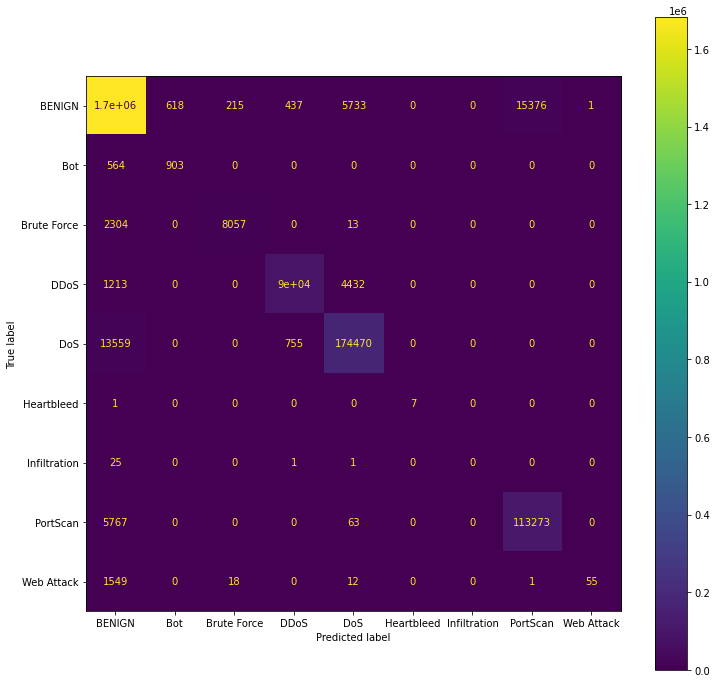

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
cm = confusion_matrix(y_train, y_train_pred)
fig, ax = plt.subplots(figsize=(12, 12))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_).plot(ax=ax)
plt.show()

In [25]:
def multilabel_matrix(y_true, y_pred, labels=None):
    mlm = multilabel_confusion_matrix(y_true, y_pred, labels=labels)
    df_performance = pd.DataFrame(index=labels, columns=['accuracy', 'precision', 'recall', 'f1_score'])
    for i, label in enumerate(labels):
        tn, fp, fn, tp = mlm[i].ravel()
        accuracy = (tn + tp) / (tn + fp + fn + tp)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)

        f1_score = 2*precision * recall / (precision + recall)
        df_performance.loc[label] = [round(accuracy, 4), round(precision,4), \
                                     round(recall, 4), round(f1_score,4)]
    return df_performance

In [21]:
# model = autoencoder_model(X_train)
# model.compile(optimizer='adam', loss='mse')
# model.summary()

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(mode='min', patience=5)

epochs = 50
batch = 64

history = model.fit(X_train, X_train,
                    epochs=epochs, batch_size=batch,
                    validation_split=0.2, callbacks=[early_stopping_callback]).history

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

In [ ]:
from keras.models import load_model
model.save('Network_LSTM_Autoencoder_model.hdf5')

In [ ]:
# # predicting on training set
# y_train_pred_prob = model.predict(X_train)
# y_test_pred_prob = model.predict(X_train)
# y_train_pred = np.argmax(y_train_pred_prob, axis=1)
# y_test_pred = np.argmax(y_test_pred_prob, axis=1)

In [26]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from itertools import cycle
def RoC_Curve(y_score, y, labels, title): 
    y_cat = to_categorical(y)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw = 2
    # First aggregate all false positive rates
    n_classes = len(labels)
#     print('n_classes:', n_classes)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_cat[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_cat.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(8,8))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.4f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.4f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=lw,
                 label=f'ROC curve of class {labels[i]} (area = {roc_auc[i]:0.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title, fontsize=16)
    plt.legend(loc="lower right")
    plt.show()

In [27]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
y_train_pred_labels = le.inverse_transform(y_train_pred)
y_train_labels = le.inverse_transform(y_train)
print(classification_report(y_train_labels, y_train_pred_labels))
performance = multilabel_matrix(y_train_pred_labels, y_train_labels, labels=le.classes_)
performance

/home/c4nd0it/anaconda3/envs/keras_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/c4nd0it/anaconda3/envs/keras_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/c4nd0it/anaconda3/envs/keras_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

              precision    recall  f1-score   support

      BENIGN       0.99      0.99      0.99   1703490
         Bot       0.59      0.62      0.60      1467
 Brute Force       0.97      0.78      0.86     10374
        DDoS       0.99      0.94      0.96     96019
         DoS       0.94      0.92      0.93    188784
  Heartbleed       1.00      0.88      0.93         8
Infiltration       0.00      0.00      0.00        27
    PortScan       0.88      0.95      0.91    119103
  Web Attack       0.98      0.03      0.07      1635

    accuracy                           0.98   2120907
   macro avg       0.82      0.68      0.70   2120907
weighted avg       0.98      0.98      0.97   2120907



/tmp/ipykernel_64183/3044907933.py:8: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp / (tp + fn)


,accuracy,precision,recall,f1_score
BENIGN,0.9777,0.9869,0.9854,0.9861
Bot,0.9994,0.6155,0.5937,0.6044
Brute Force,0.9988,0.7767,0.9719,0.8634
DDoS,0.9968,0.9412,0.987,0.9635
DoS,0.9884,0.9242,0.9445,0.9342
Heartbleed,1.0,0.875,1.0,0.9333
Infiltration,1.0,0.0,NaN,NaN
PortScan,0.99,0.9511,0.8805,0.9144
Web Attack,0.9993,0.0336,0.9821,0.0651


In [28]:
y_test_pred_labels = le.inverse_transform(y_test_pred)
y_test_true_labels = le.inverse_transform(y_test)
print(classification_report(y_test_true_labels,y_test_pred_labels))

/home/c4nd0it/anaconda3/envs/keras_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/c4nd0it/anaconda3/envs/keras_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      BENIGN       0.99      0.99      0.99    567830
         Bot       0.58      0.64      0.61       489
 Brute Force       0.97      0.78      0.87      3458
        DDoS       0.99      0.94      0.96     32006
         DoS       0.94      0.92      0.93     62928
  Heartbleed       1.00      0.67      0.80         3
Infiltration       0.00      0.00      0.00         9
    PortScan       0.88      0.95      0.92     39701
  Web Attack       1.00      0.04      0.08       545

    accuracy                           0.98    706969
   macro avg       0.82      0.66      0.68    706969
weighted avg       0.98      0.98      0.97    706969



/home/c4nd0it/anaconda3/envs/keras_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
performance = multilabel_matrix(y_test_true_labels, y_test_pred_labels, labels=le.classes_)
performance

/tmp/ipykernel_64183/3044907933.py:7: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


,accuracy,precision,recall,f1_score
BENIGN,0.9777,0.9855,0.9868,0.9862
Bot,0.9994,0.5844,0.6442,0.6128
Brute Force,0.9988,0.9743,0.7779,0.8651
DDoS,0.9967,0.9865,0.9409,0.9632
DoS,0.9883,0.9437,0.9235,0.9335
Heartbleed,1.0,1.0,0.6667,0.8
Infiltration,1.0,NaN,0.0,NaN
PortScan,0.9902,0.8812,0.9534,0.9159
Web Attack,0.9993,1.0,0.0422,0.081


: 

In [ ]:
# from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
# scaler = MinMaxScaler()
# le = LabelEncoder()

# X_train_split = scaler.fit_transform(X_train_split)
# X_test_split = scaler.transform(X_test_split)
# y_train_split = le.fit_transform(y_train_split)
# y_test_split = le.transform(y_test_split)

In [ ]:
# X_train_split = X_train_split.reshape(X_train_split.shape[0], 1, X_train_split.shape[1])
# print("Training data shape:", X_train_split.shape)
# X_test_split = X_test_split.reshape(X_test_split.shape[0], 1, X_test_split.shape[1])
# print("Test data shape:", X_test_split.shape)

In [ ]:
# no_label_df = df.drop(columns='Label')
# no_label_df

In [ ]:
# X_pred = model.predict(X_train_split)
# X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
# X_pred = pd.DataFrame(X_pred, columns=no_label_df.columns)
# X_pred.index = no_label_df.index
# scored = pd.DataFrame(index=X_train_split.index)
# Xtrain = X_train.reshape(X_train_split.shape[0], X_train_split.shape[2])
# scored['Loss_mse'] = np.mean(np.square(X_pred-Xtrain), axis = 1)
# plt.figure(figsize=(16,9), dpi=80)
# plt.title('Loss Distribution', fontsize=16)
# sns.distplot(scored['Loss_mse'], bins = 20, kde= True, color = 'blue');
# plt.xlim([0.0,.5])